# Train Review Analysis

### Introduction

In this assignment I have been tasked with extracting and analyzing the major topics of a dataset of train service reviews.  
This notebook contains the main analysis for the assignment and all relevant visualizations.  
There are some extra basic analyses of the data in basic_analysis.ipynb

### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from collections import defaultdict
from utils import (pretty_print_row, extract_company, clean_rating, generate_ngrams, plot_ngrams)

print('Imports Complete')

Imports Complete


### Ingest Data

In [2]:
# Reading Data
df = pd.read_json('./data/train_reviews.json')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
date     2021 non-null datetime64[ns, UTC]
title    2021 non-null object
text     2021 non-null object
url      2021 non-null object
stars    2021 non-null object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 47.4+ KB
None


From the dataframe info we can see that there are about 2000 records with 5 columns each and no null values.    
Next step is to check for duplicates and drop them, then start cleaning/wrangling the data.

### Drop Duplicates

In [3]:
# Check for duplicates
duplicated_df = df[df.duplicated(subset=['date', 'title', 'text', 'stars'], keep='first') == True]
print(duplicated_df.shape)

# Dropping duplicates
df = df.drop_duplicates(subset=['date', 'title', 'text', 'stars'], keep='first')
print(df.shape)

(580, 5)
(1441, 5)


From this we can see that a very significant portion of the dataset is duplicated data (~25%).  
While it is a bit painful to lose so much data we have no choice but to drop the duplicates as it will greatly skew the analysis.

Note that we leave out the 'url' feature when detecting duplicates because there are multiple examples of records with exactly the same title, text, date, and rating but a slightly different url.

### Clean Data and Minor Feature Engineering

In [4]:
# Printing out a record to get a better idea of what the comments look like
pretty_print_row(df=df, index=0)

Date: 2015-10-10 14:32:51+00:00
Title: Bad customer service. Staff are very impolite and rude
Text: Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.
URL: https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4
Stars: star-rating star-rating-1 star-rating--medium


1    1129
5     121
2     107
4      45
3      39
Name: rating, dtype: int64


<AxesSubplot:ylabel='rating'>

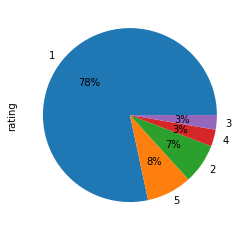

In [5]:
# Cleaning the stars feature to a simple int 
df['rating'] = df.stars.apply(lambda x: clean_rating(x)).astype('int32')
print(df.rating.value_counts())

df.rating.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [6]:
# Cleaning url column
df['company'] = df['url'].apply(lambda x: extract_company(x))
company_counts = df.company.value_counts()
print(company_counts)

www.virgintrains.co.uk                     480
www.southernrailway.com                    260
www.eurostar.com                           180
www.gwr.com                                180
www.virgintrainseastcoast.com              120
www.nationalrail.co.uk                      65
www.arrivatrainswales.co.uk                 20
www.buytickets.crosscountrytrains.co.uk     20
www.eastmidlandstrains.co.uk                20
www.southeasternrailway.co.uk               20
www.tpexpress.co.uk                         20
www.grandcentralrail.com                    19
www.southwesternrailway.com                 13
www.londonnorthwesternrailway.co.uk          8
chilternrailways.co.uk                       8
sleeper.scot                                 6
www.hulltrains.co.uk                         2
Name: company, dtype: int64


Here we clean away the unnecessary part of the url like the page number so that we have distinct names/urls per company.  
This allows us to get a better idea of how the comments are split up by company and we see that the reviews are very skewed towards 5 companies that have more than 80% of the reviews.

In [7]:
# Investigating average rating per company
companies = list(company_counts.keys())

print('Overall rating average: ' + str(np.asarray(df.rating).mean()))
print('Per Company:\n')
for c in companies:
    company_mean = df[df['company'] == c]['rating'].mean()
    print('Company: ' + c + '  Rating: ' + str(company_mean))

Overall rating average: 1.55794587092297
Per Company:

Company: www.virgintrains.co.uk  Rating: 1.8458333333333334
Company: www.southernrailway.com  Rating: 1.1961538461538461
Company: www.eurostar.com  Rating: 1.4444444444444444
Company: www.gwr.com  Rating: 1.3055555555555556
Company: www.virgintrainseastcoast.com  Rating: 1.7083333333333333
Company: www.nationalrail.co.uk  Rating: 1.5846153846153845
Company: www.arrivatrainswales.co.uk  Rating: 1.7
Company: www.buytickets.crosscountrytrains.co.uk  Rating: 1.0
Company: www.eastmidlandstrains.co.uk  Rating: 1.4
Company: www.southeasternrailway.co.uk  Rating: 1.75
Company: www.tpexpress.co.uk  Rating: 1.5
Company: www.grandcentralrail.com  Rating: 1.8421052631578947
Company: www.southwesternrailway.com  Rating: 1.0
Company: www.londonnorthwesternrailway.co.uk  Rating: 1.125
Company: chilternrailways.co.uk  Rating: 2.125
Company: sleeper.scot  Rating: 2.5
Company: www.hulltrains.co.uk  Rating: 4.5


Looking at the distribution of the ratings we see that the vast majority of ratings are negative with 78% of comments rated 1 star.  
When we look at ratings on a per company basis we see a similar trend with low ratings across the board and the only companies with greater than a 2 star average being those that have very few comments.  
It appears that overall, based on this dataset, peoples experience with the uk train systems are quite negative.  
Lets look into the topics of the comments and see if we can get an idea of why people are having a bad time.

## Analyzing Topics through Ngrams

For the task of extracting the topics of the comments I decided to investigate the most common ngrams, specifically unigrams, bigrams, and trigrams.  
I believe that this will give a clear picture of the main complaints/compliments that are present within the comments.

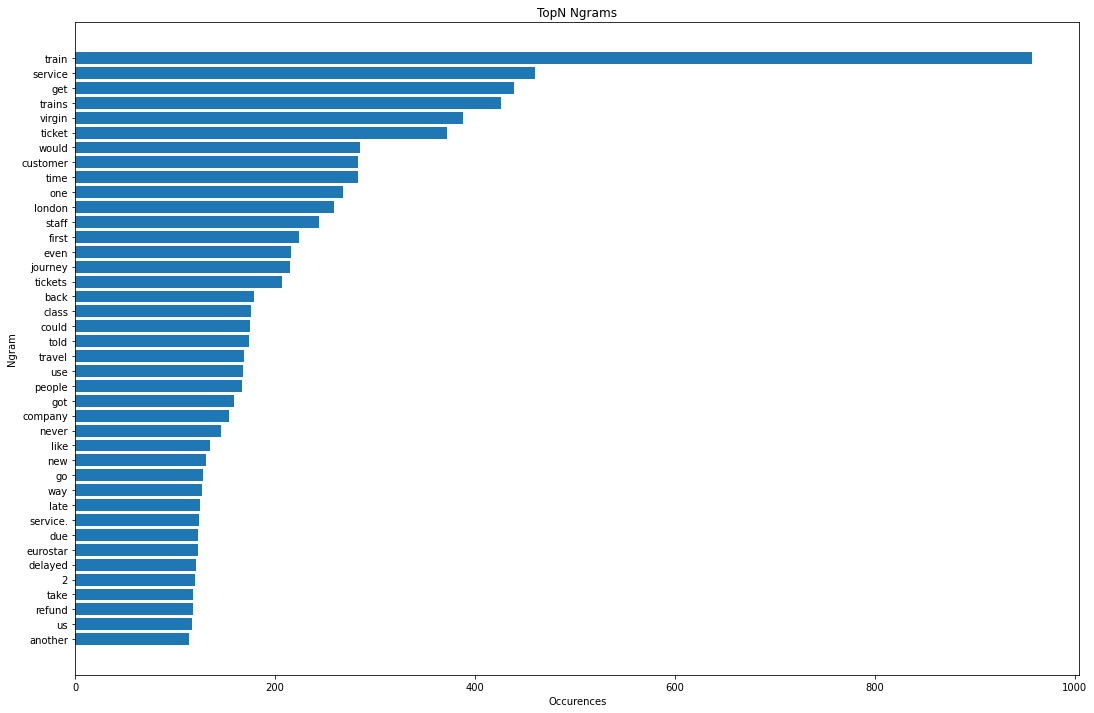

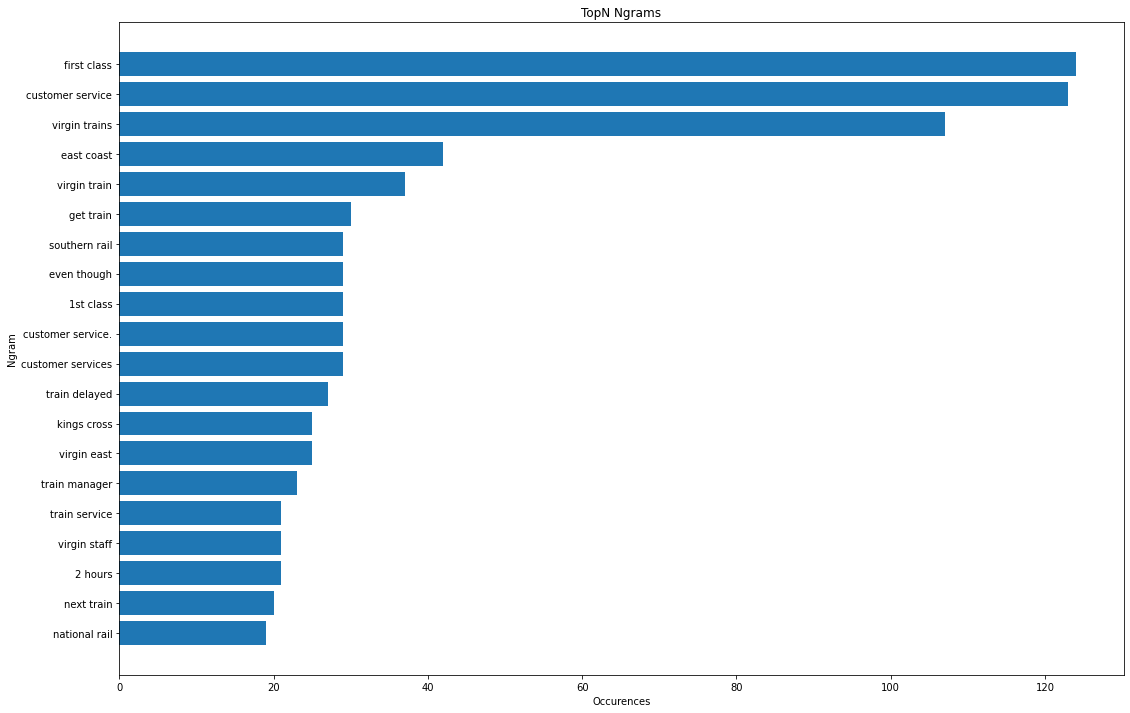

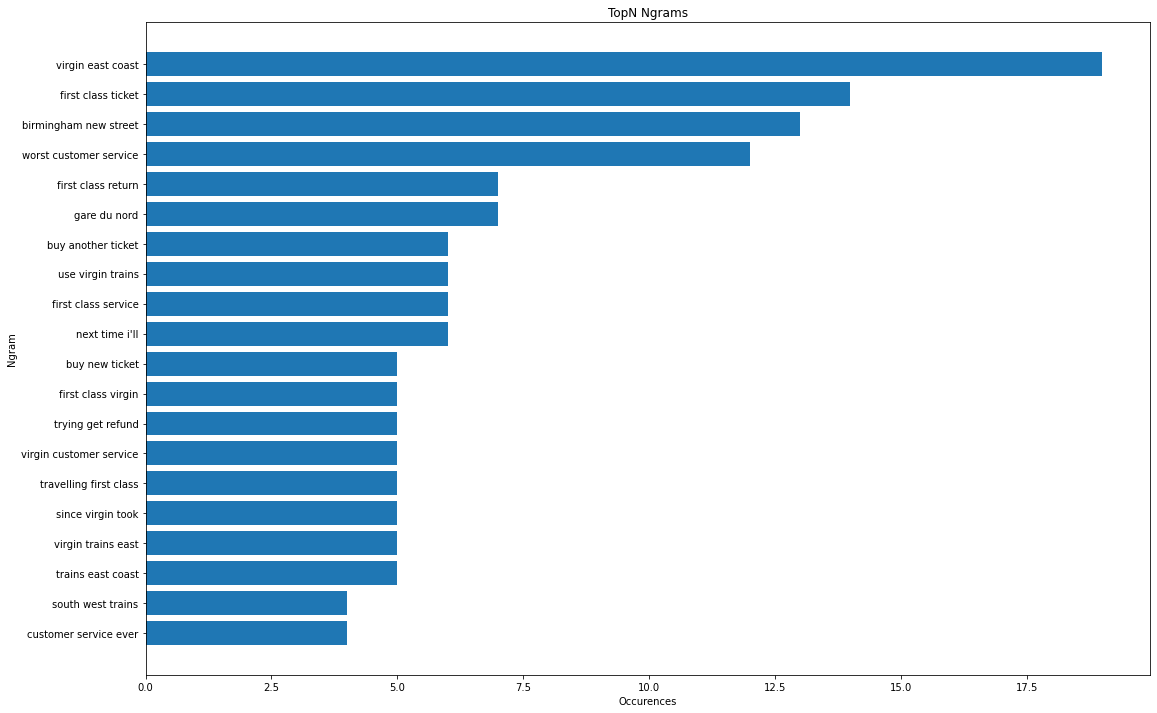

In [8]:
# Plotting uni, bi, and tri grams for the whole dataset
plot_ngrams(df, 1, 40, (18,12), color=u'#1f77b4')
plot_ngrams(df, 2, 20, (18,12), color=u'#1f77b4')
plot_ngrams(df, 3, 20, (18,12), color=u'#1f77b4')

Based on the top ngrams from the whole dataset we can see that the most common topics are cusomer service, first class service, delays/cancellations, and ticketing issues/refunds.  
Looking across all three groups of ngrams it is clear that customer service/staffing is the top topic with the most mentions across all of its permutations.  
Next well take a deeper look into how the ratings and topics change over time and with respect to the rating.

## Looking at distribution of data over time

2017    548
2018    536
2016    287
2015     68
2011      2
Name: year, dtype: int64


c:\users\wilso\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\wilso\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\wilso\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not lay

<AxesSubplot:xlabel='year'>

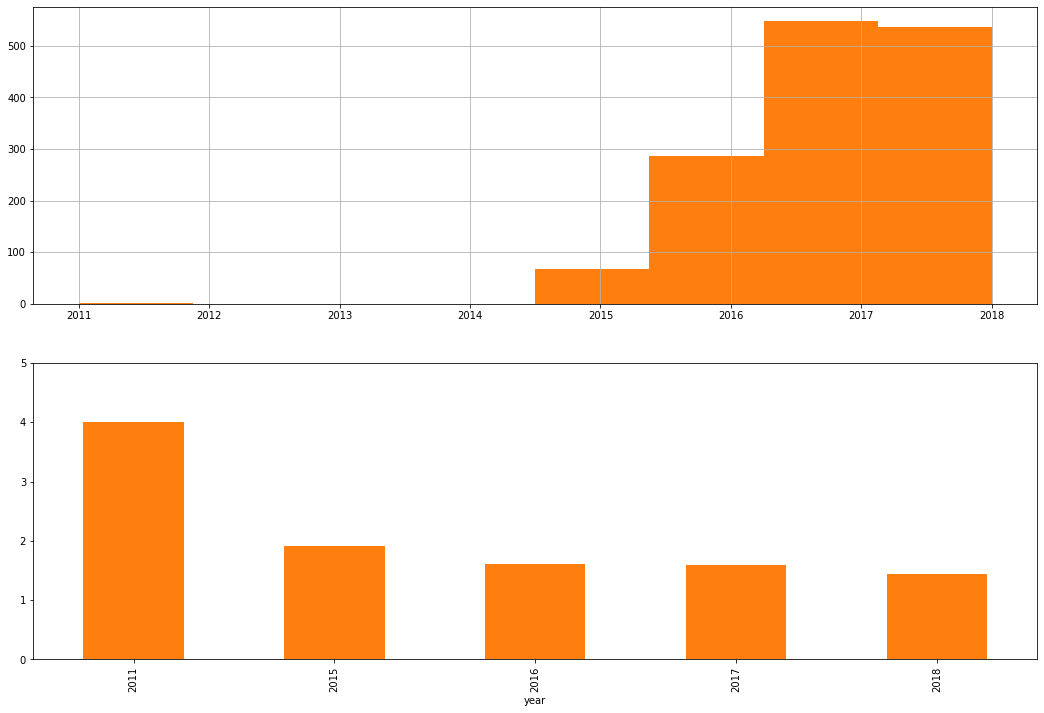

In [9]:
# Start looking at data based on time(positive/negative ratings over time)
df['year'] = df['date'].apply(lambda x: x.year)
print(df['year'].value_counts())

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,12))
ax[1].set_ylim(0,5)

df['year'].hist(bins=8, ax=ax[0], color=u'#ff7f0e')
df.groupby('year')['rating'].mean().plot(kind='bar', ax=ax[1], color=u'#ff7f0e')

When we break down the data based on the year of the review we can see that most of the data is coming from 2017 and 2018.  
Next we plot the average rating per year, and see that the rating for the train services has been dropping steadily over time.  
However it should be noted that in 2011 there were very few reviews so the high average does not carry as much weight.  

## Plotting topics(ngrams) over time

Here we look at the ngrams for each year in which there is sufficient data in an attempt to see any patterns or changes over time in the topics.

(68, 8)


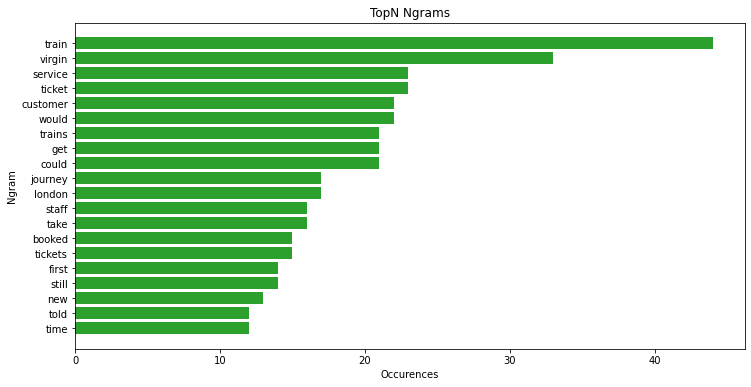

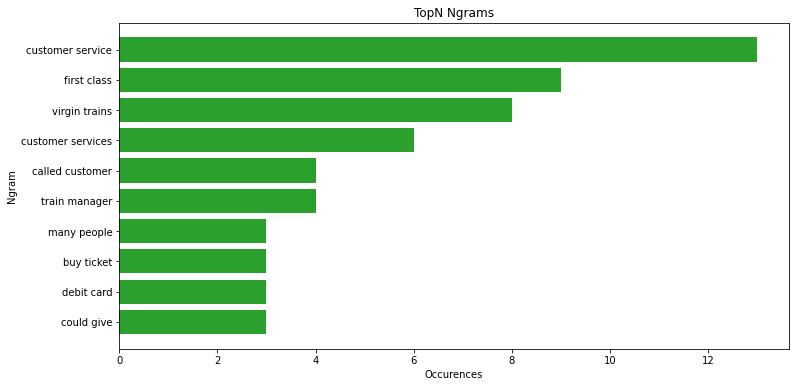

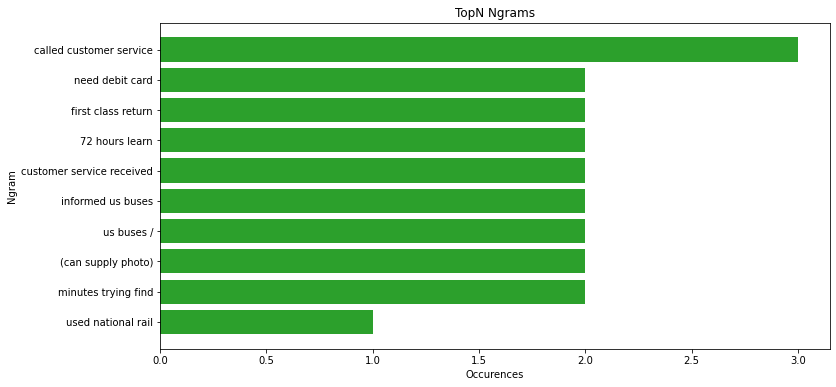

In [10]:
# Plotting bigrams in different years to see changes over time :: 2015

print(df[df['year'] == 2015].shape)
plot_ngrams(df[df['year'] == 2015], 1, 20, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2015], 2, 10, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2015], 3, 10, (12, 6), color=u'#2ca02c')

(287, 8)


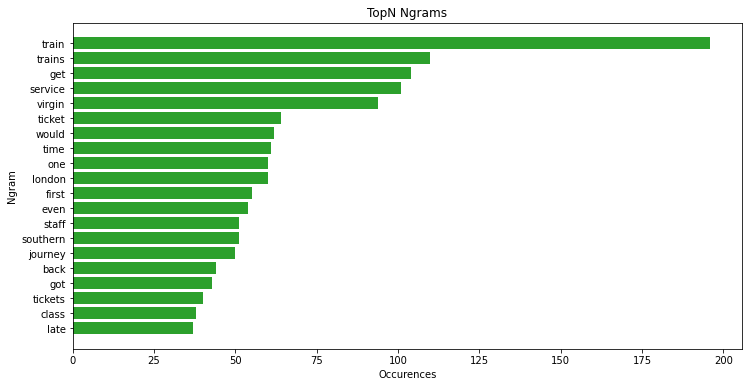

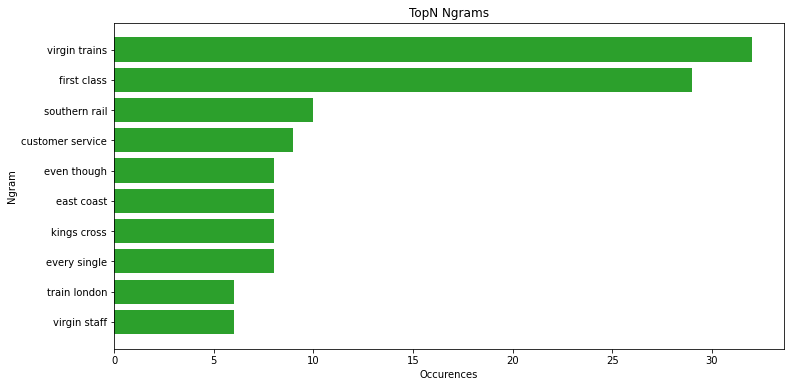

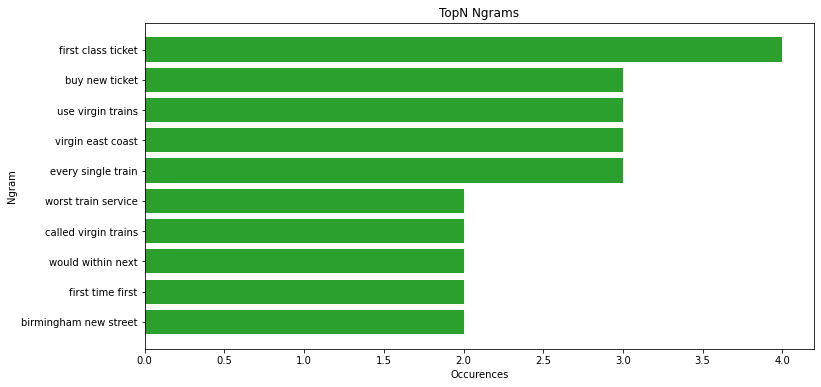

In [11]:
# 2016
print(df[df['year'] == 2016].shape)
plot_ngrams(df[df['year'] == 2016], 1, 20, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2016], 2, 10, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2016], 3, 10, (12, 6), color=u'#2ca02c')

(548, 8)


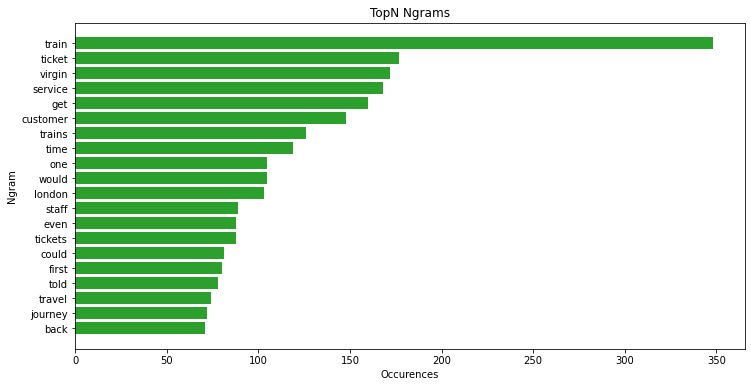

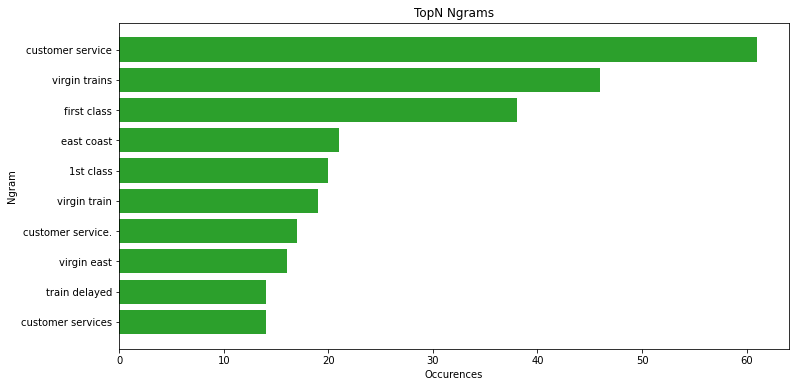

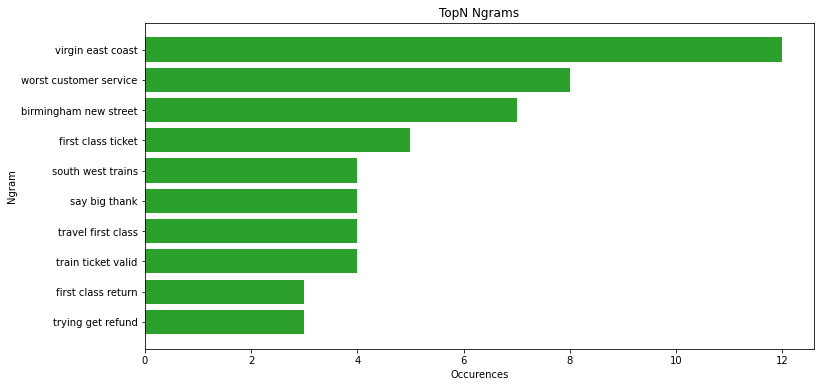

In [12]:
# 2017
print(df[df['year'] == 2017].shape)
plot_ngrams(df[df['year'] == 2017], 1, 20, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2017], 2, 10, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2017], 3, 10, (12, 6), color=u'#2ca02c')

(536, 8)


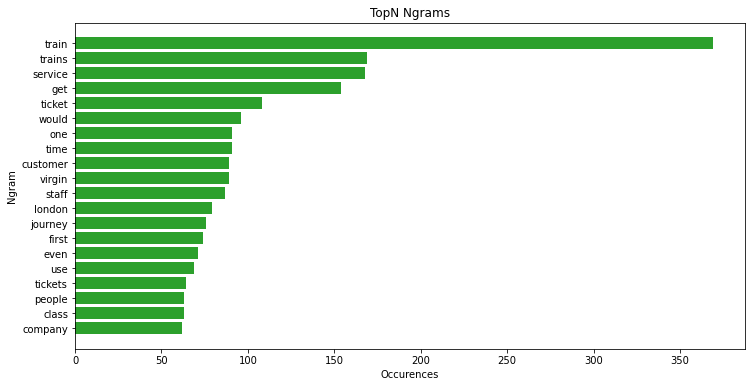

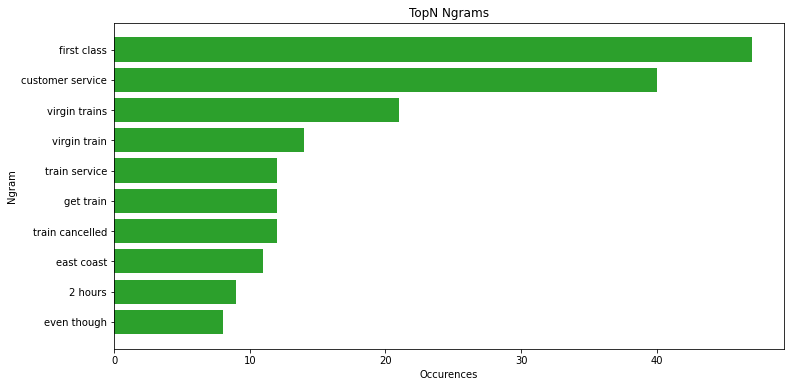

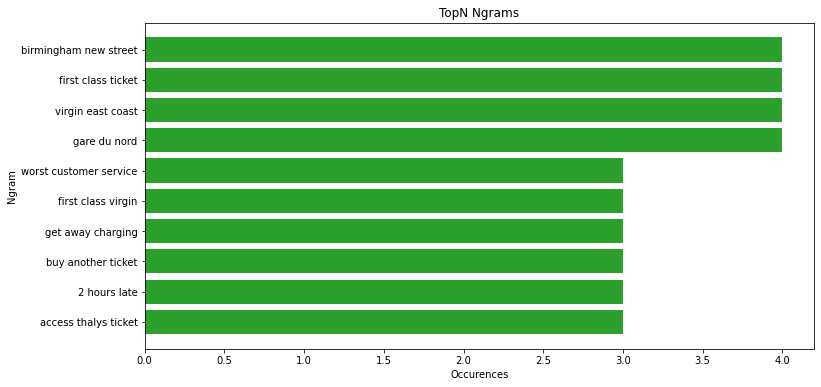

In [13]:
# 2018
print(df[df['year'] == 2018].shape)
plot_ngrams(df[df['year'] == 2018], 1, 20, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2018], 2, 10, (12, 6), color=u'#2ca02c')
plot_ngrams(df[df['year'] == 2018], 3, 10, (12, 6), color=u'#2ca02c')

### Analysis

As should be expected, customer service and first class service are always common topics regardless of the year. This could also be due to the fact that these topics/ngrams appear in both positive and negative reviews(Investigated more in basic_analysis.ipynb).

In terms of trends over time we can see that in 2015-2016 most topics are about universal topics like customer service, ticketing, etc...  
However in 2017-2018 topics around train delays and cancellations start entering the top 10 topics (i.e. train delayed, train cancelled, 2 hours late).  
It seems as though there are significantly more complaints about delays and cancellations in recent years (perhaps due to schedule change?).  
This could be something for the client or train companies to investigate if they want to turn around the declining rating trend.  